In [1]:
from sklearn.datasets import fetch_openml # getting common datasets from sklearn datasets
# fetch_mldata is obsolete as it fetches data from died website, we need to replace it with fetch_openml
# https://www.openml.org/home
import numpy as np
import pandas as pd
from os import path, getcwd

In [2]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
#mnist

In [3]:
# getting data and target from mnist dataset
X, y = mnist["data"], mnist["target"]
print(f"Shape X : {X.shape}, y : {y.shape}")

Shape X : (70000, 784), y : (70000,)


In [4]:
# The data set contains 70000 rows and 784 columns. Every feature is the pixel of intensity from 0 (White) to 255 (Black).
# Lets peek at one of the digit.
import matplotlib
import matplotlib.pyplot as plt

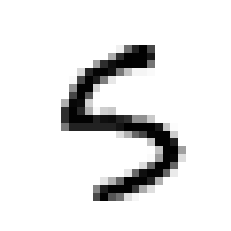

In [5]:
some_digit = X[15000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

In [6]:
# It looks like 5 but lets check it with label
y[15000]

5

In [7]:
# lets split test and train data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
# Shuffling the dataset
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]


### Training Binary Classifier

In [9]:
y_train_5 = (y_train == 5) # True for all 5's and False for otherwise
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier # Stochastic (Randomness) Gradient Decent classifier is 
# capable to handle large datasets

In [11]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9594, 0.9426, 0.9604])

In [14]:
# Lets check accuracy on very dumb classifier which justs evaluate every single image to not-5-class
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
# accuracy of this classifier
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9098 , 0.90875, 0.9104 ])

In [16]:
# This is because only 10% of data has 5

print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


In [17]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) 
# TN FP
# FN TP

array([[53378,  1201],
       [ 1551,  3870]])

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_train_5, y_train_pred) # TP / (TP + FP) => 4238/5279 = 0.80
recall = recall_score(y_train_5,y_train_pred) # TP / (TP + FN) => 4238/5421 = 0.78
print(f"Only detects {precision * 100}% of 5s, Only correct {recall*100}% times")

Only detects 76.31630842042989% of 5s, Only correct 71.38904261206419% times


In [20]:
# F1 scores uses harmonic mean whereas regular mean treats all values equally.
f1 = f1_score(y_train_5, y_train_pred)
print(f"F1 = {f1}")

F1 = 0.7377049180327869


In [21]:
# Lets train randomforest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [22]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_forest

array([[0.97, 0.03],
       [0.96, 0.04],
       [0.95, 0.05],
       ...,
       [0.92, 0.08],
       [0.87, 0.13],
       [0.94, 0.06]])

In [23]:
y_scores_forest = y_probas_forest[:,1]

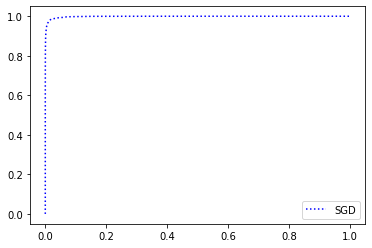

In [24]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr_forest,tpr_forest,"b:",label="SGD")
plt.legend(loc="lower right")
plt.show()

In [25]:
roc_auc_score(y_train_5, y_scores_forest)

0.9985526143013389

In [26]:
# now we want to evaluate these classifiers
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8616 , 0.86075, 0.8852 ])

In [27]:
# lets try scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_trained_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_trained_scaled


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
# lets check classifier with scaled values
cross_val_score(sgd_clf, X_trained_scaled, y_train, cv=3, scoring = "accuracy")

array([0.89385, 0.9013 , 0.907  ])